In [14]:
import cv2
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import math
# from torchvision.references.detection.engine import train_one_epoch, evaluate
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
import rcnn
import img_lib
import backbone

import importlib
importlib.reload(rcnn)
importlib.reload(img_lib)
# importlib.reload(backbone)

<module 'img_lib' from '/home/kevin/Documents/dmp_testing/img_lib.py'>

In [16]:
model = rcnn.get_rcnn("rcnn.pt")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0], std=[1])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Sequential(
   

In [17]:
train_ds = rcnn.RCNNImgDataset("strokes/data.pkl", img_lib.STROKES, max_strokes=3, min_strokes=2)

In [18]:
STROKES = ["", "spiral", "box", "triangle", "plus", "circle", "star"]

COLORS = np.random.uniform(0, 255, size=(len(STROKES), 3))

def draw_boxes(boxes, labels, scores, image):
    # read the image with OpenCV
    if type(image) == torch.Tensor:
        image = (image.numpy() * 255).astype(np.uint8)
    if image.shape[0] == 1: # channels
        image = image.transpose(1,2,0)
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, f"{STROKES[labels[i]]}:{scores[i]:.2f}", (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    
    return image


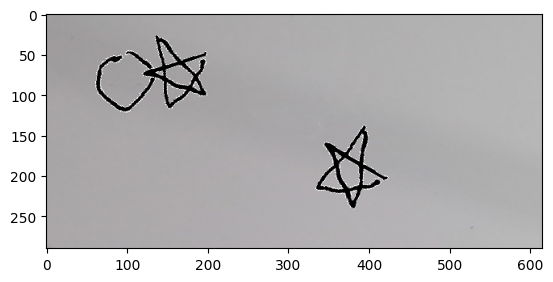

In [19]:
plt.imshow(img_lib.get_realistic_image())

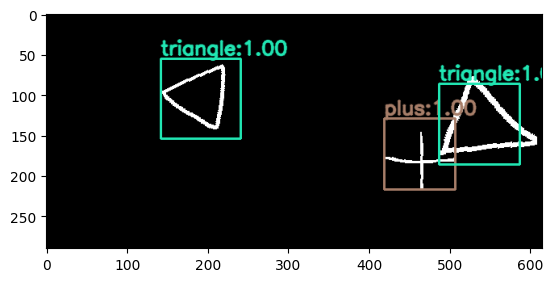

In [20]:
res = train_ds[0]
boxes = res[1]["boxes"]
labels = res[1]["labels"]
img_boxed = img_lib.draw_boxes(boxes, labels, [1] * len(labels), res[0])
plt.imshow(img_boxed);

# end to end system

In [21]:
random.seed(23)


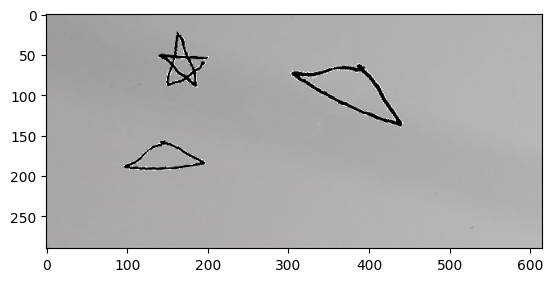

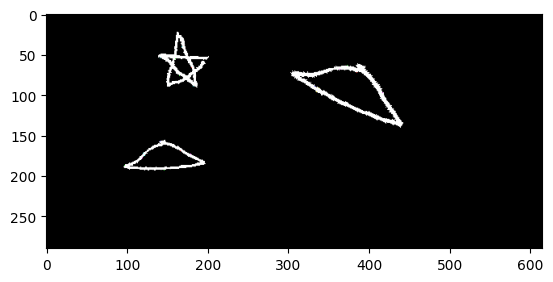

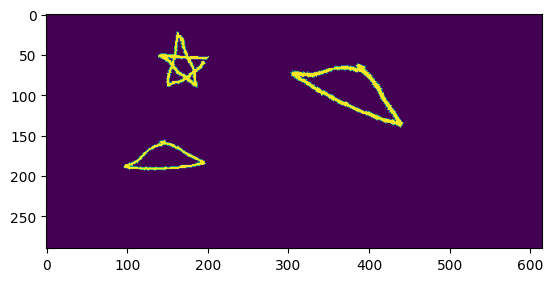

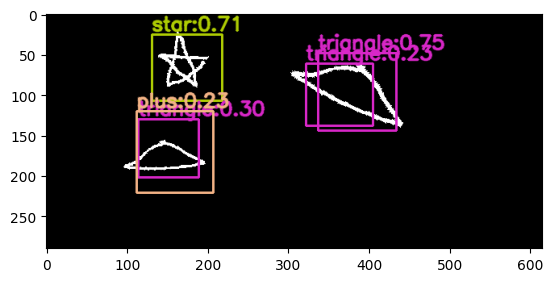

In [22]:
importlib.reload(img_lib)
img = img_lib.get_realistic_image()
plt.imshow(img)
plt.show()

with open("strokes/data.pkl","rb") as f:
    data = pickle.load(f)
base = data['base']
img = img_lib.remove_bg(img, base)
plt.imshow(img)
plt.show()

img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)[:,:,None]
plt.imshow(img)
plt.show()

out = model(img_lib.prep_tensor(img))
boxes, labels, scores = rcnn.filter_results(out, topn=5)
img_boxed = img_lib.draw_boxes(boxes, labels, scores, img)
plt.imshow(img_boxed);
plt.show()

In [23]:
out

[{'boxes': tensor([[337.7314,  48.8689, 434.2422, 144.4645],
          [131.7244,  25.8582, 218.3003, 107.4738],
          [114.2826, 130.1023, 189.1055, 202.8658],
          [322.3273,  61.7471, 405.1049, 138.0179],
          [112.3989, 120.3065, 207.1417, 221.0371],
          [148.5984,  30.5775, 231.1342, 110.9693],
          [128.9907,  17.4432, 226.8991, 104.6954],
          [307.7440,  45.5726, 388.6906, 124.8149],
          [ 85.3540, 123.2735, 159.8851, 199.9078],
          [339.8091,  59.9247, 427.4822, 154.7063],
          [117.3716,  37.6000, 192.8411, 113.5693],
          [331.4705,  53.8098, 429.8046, 156.4277],
          [307.8224,  37.0177, 410.2780, 137.6487],
          [263.4503,  32.1669, 347.0893, 113.2956],
          [289.3251,  44.6829, 371.1527, 125.4602],
          [139.4097, 139.4176, 207.2281, 206.8074],
          [115.3492,  23.6980, 214.0509, 117.6324],
          [365.0375,  90.5823, 441.2540, 159.2145],
          [ 80.1728, 125.6156, 179.3346, 219.2944],
   

In [24]:
def e2e(img):
    plt.imshow(img)
    plt.show()
    with open("strokes/data.pkl","rb") as f:
        data = pickle.load(f)
    base = data['base']
    img = img_lib.remove_bg(img, base)
    plt.imshow(img)
    plt.show()

    img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)[:,:,None]
    plt.imshow(img)
    plt.show()

    out = model(img_lib.prep_tensor(img))
    boxes, labels, scores = rcnn.filter_results(out, topn=1)
    print(scores)
    img_boxed = img_lib.draw_boxes(boxes, labels, scores, img)
    plt.imshow(img_boxed);
    plt.show()

real_imgs/triangle.png


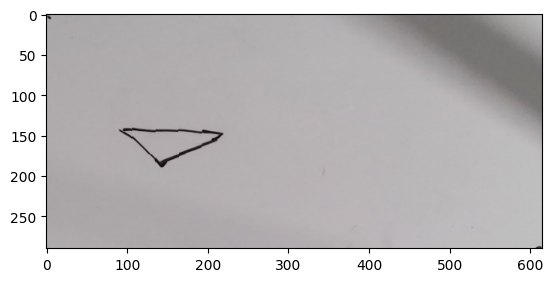

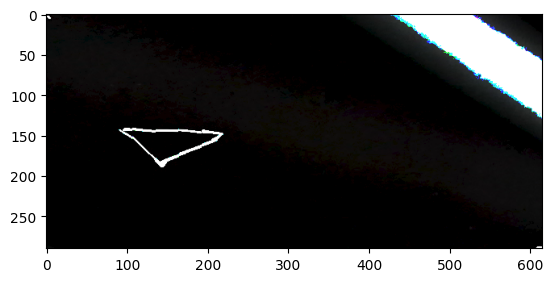

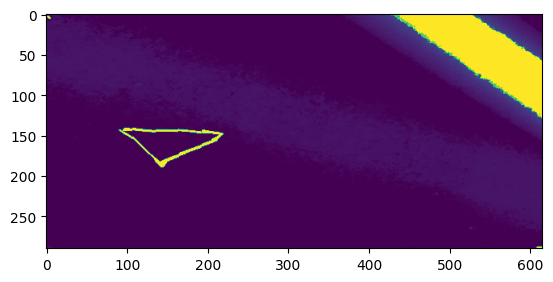

[0.39354628324508667]


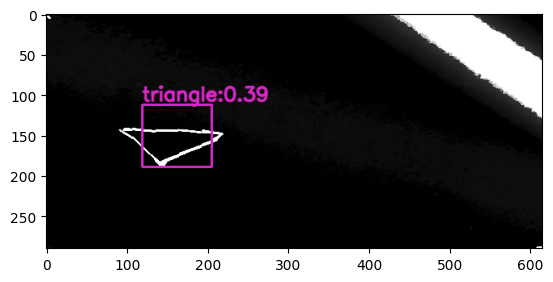

real_imgs/circle.png


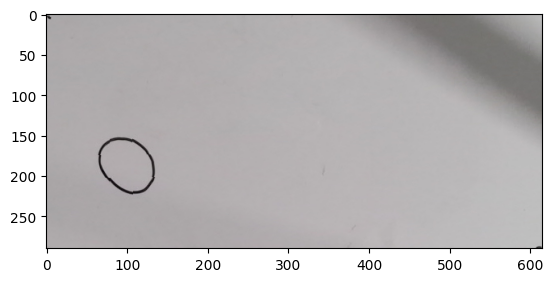

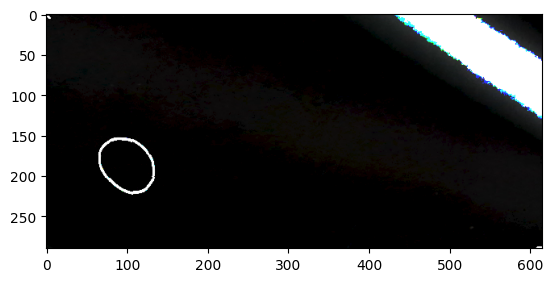

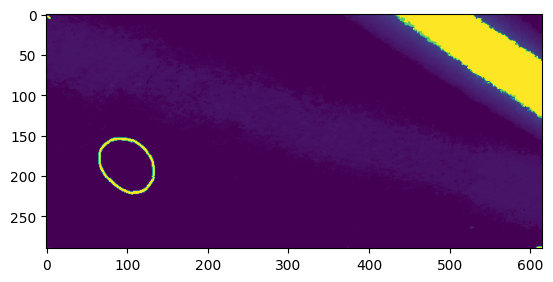

[0.4829333424568176]


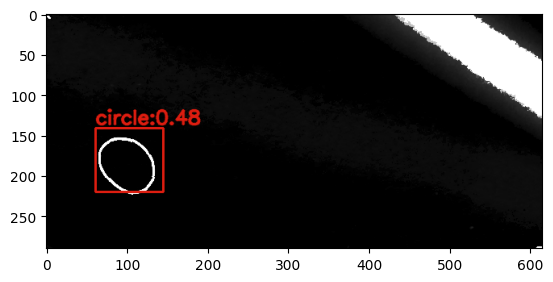

real_imgs/circle1.png


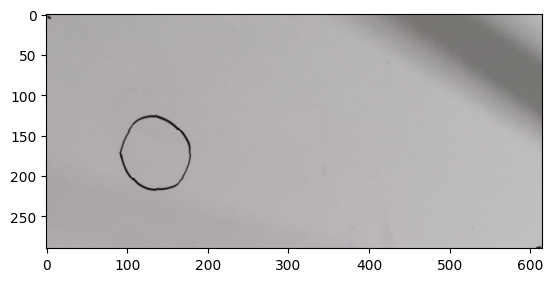

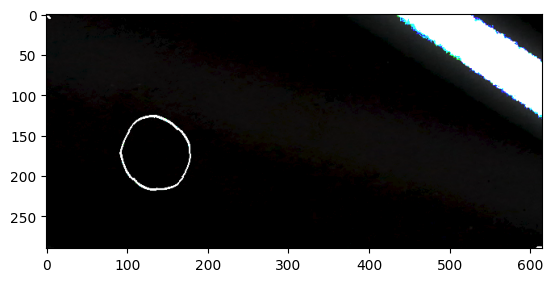

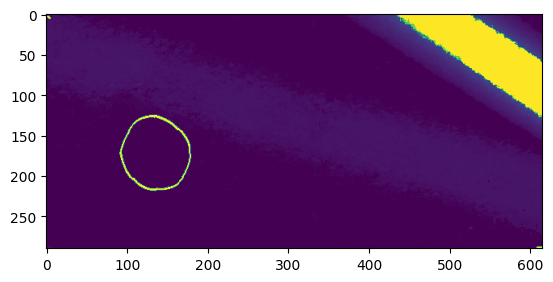

[0.5299084782600403]


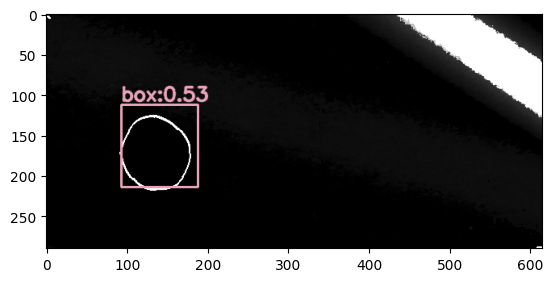

real_imgs/star1.png


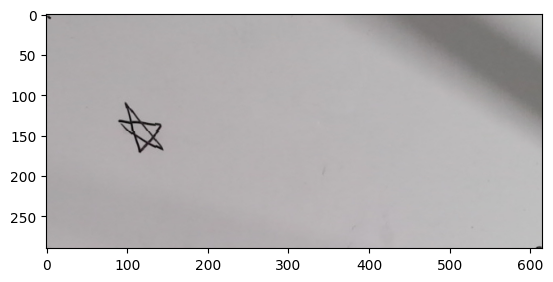

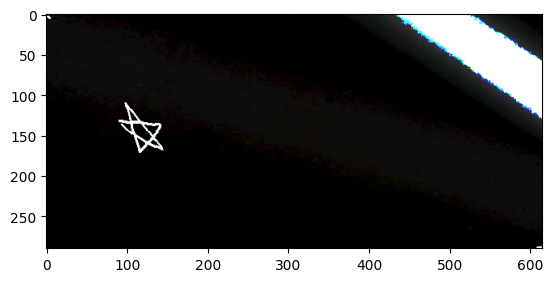

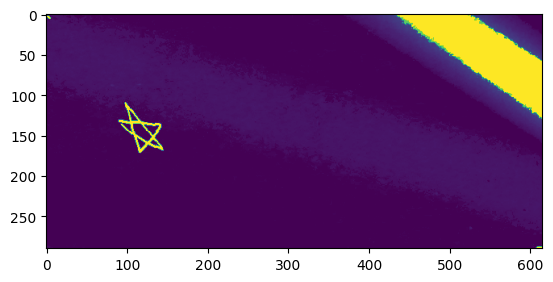

[0.5228097438812256]


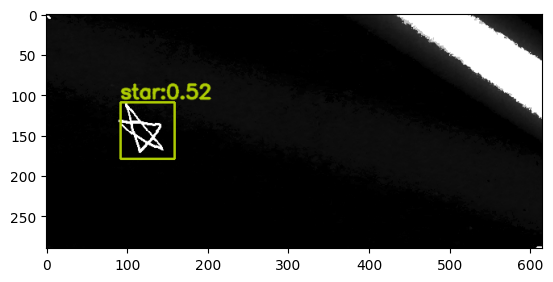

real_imgs/spiral.png


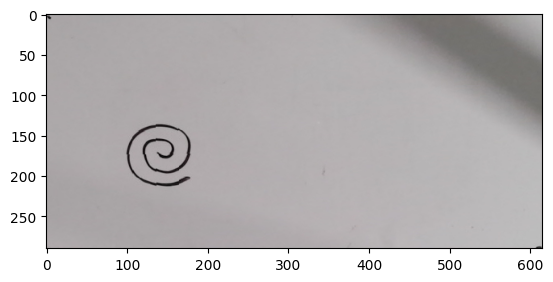

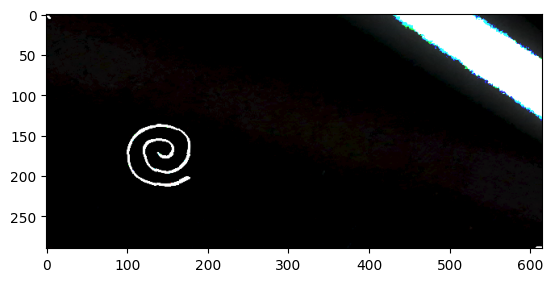

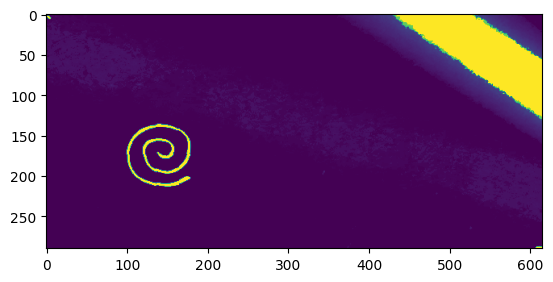

[0.7446865439414978]


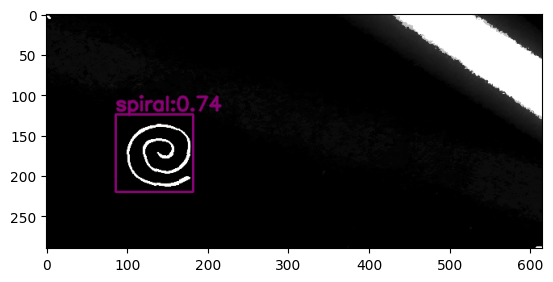

In [25]:
import os
root = "real_imgs"
for i in os.listdir(root):
    p = os.path.join(root, i)
    img = cv2.imread(p)
    img = img_lib.prep_img(img)
    print(p)
    e2e(img)
    

In [26]:
importlib.reload(img_lib)
out

[{'boxes': tensor([[337.7314,  48.8689, 434.2422, 144.4645],
          [131.7244,  25.8582, 218.3003, 107.4738],
          [114.2826, 130.1023, 189.1055, 202.8658],
          [322.3273,  61.7471, 405.1049, 138.0179],
          [112.3989, 120.3065, 207.1417, 221.0371],
          [148.5984,  30.5775, 231.1342, 110.9693],
          [128.9907,  17.4432, 226.8991, 104.6954],
          [307.7440,  45.5726, 388.6906, 124.8149],
          [ 85.3540, 123.2735, 159.8851, 199.9078],
          [339.8091,  59.9247, 427.4822, 154.7063],
          [117.3716,  37.6000, 192.8411, 113.5693],
          [331.4705,  53.8098, 429.8046, 156.4277],
          [307.8224,  37.0177, 410.2780, 137.6487],
          [263.4503,  32.1669, 347.0893, 113.2956],
          [289.3251,  44.6829, 371.1527, 125.4602],
          [139.4097, 139.4176, 207.2281, 206.8074],
          [115.3492,  23.6980, 214.0509, 117.6324],
          [365.0375,  90.5823, 441.2540, 159.2145],
          [ 80.1728, 125.6156, 179.3346, 219.2944],
   